In [1]:
# import necessary packages
import numpy as np
import torch
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64) # set arithmetic to be double precision
plt.rcParams.update({'font.size': 20}) # set font size in all plots

In [2]:
# define the exact solution
def ExactSolution(x,y):
    #(2-pi^2y^2)sin(pix)
    return (y**2)*np.sin(np.pi*x)

In [3]:
def prepare_data(xmin,xmax,nx,ymin,ymax,ny,strip_bdry):
    x1 = torch.linspace(xmin,xmax,steps = nx)
    y1 = torch.linspace(ymin,ymax,steps = ny)
    if strip_bdry == True:
        grid_x, grid_y = torch.meshgrid(x1[1:nx-1],y1[1:ny-1],indexing = 'ij')
    else:
        grid_x, grid_y = torch.meshgrid(x1,y1,indexing = 'ij')
    xcol = torch.reshape(grid_x,(grid_x.numel(),1))
    ycol = torch.reshape(grid_y,(grid_y.numel(),1))
    data_matrix = torch.cat((xcol,ycol),1)
    return grid_x, grid_y, data_matrix

Text(0.5, 1.0, 'Exact sol. and train pts')

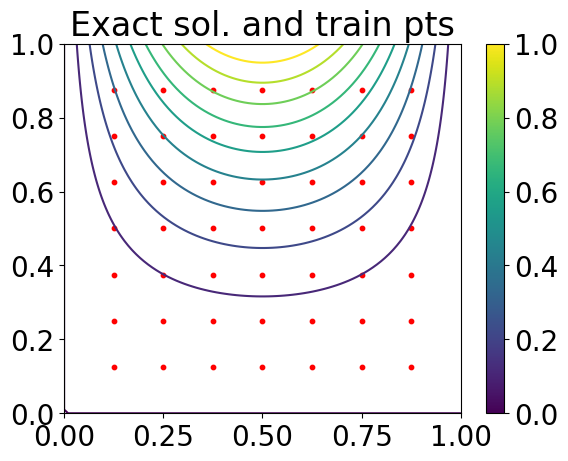

In [4]:
# define training points
npt1 = 9
strip_boundary = True
xtrain_grid, ytrain_grid, xytrain = prepare_data(0.,1.,npt1,0.,1.,npt1,strip_boundary)

# define test points
npt2 = 100
strip_boundary = False
xtest_grid, ytest_grid, xytest = prepare_data(0.,1.,npt2,0.,1.,npt2,strip_boundary)

# find the exact solution at the test points
sol_exact = ExactSolution(xtest_grid,ytest_grid)
sol_exact_vector = torch.reshape(sol_exact,(torch.numel(sol_exact),1))
sol_min = torch.min(sol_exact_vector)
sol_max = torch.max(sol_exact_vector)

# plot the exact solution and the training points
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_exact,torch.arange(sol_min,sol_max,(sol_max-sol_min)*0.1))  
plt.scatter(xytrain[:,0],xytrain[:,1],s = 10, c = '#FF0000')
plt.colorbar()
plt.title("Exact sol. and train pts")



In [256]:
# define activation function
def ActiveFun(x):
    # tanh
    sech = lambda x: 1/torch.cosh(x)
    ActFun = torch.tanh(x);
    dActFun = 1/torch.cosh(x).pow(2); # 1./cosh(x).^2
    d2ActFun = -2*torch.sinh(x)/torch.cosh(x).pow(3); # -2*sinh(x)./cosh(x).^3
    d3ActFun = (4*torch.sinh(x).pow(2)-2)/torch.cosh(x).pow(4); # (4*sinh(x).^2-2)./cosh(x).^4
    d4ActFun = 16*torch.tanh(x)*sech(x)**4-8*torch.tanh(x).pow(3)*sech(x)**2
    return ActFun, dActFun, d2ActFun, d3ActFun, d4ActFun

def ActiveFun2(x):
    #sigmoid
    ActFun = 1/(1 + torch.exp(-x))
    dActFun = ActFun*(1-ActFun)
    d2ActFun = -(torch.exp(x)*(torch.exp(x)-1))/((torch.exp(x)+1)**3)
    d3ActFun = (torch.exp(x)*(-4*torch.exp(x)+torch.exp(2*x)+1))/((torch.exp(x)+1)**4)
    d4ActFun = -(torch.exp(-x)/(torch.exp(-x)+1)**2)+(14*torch.exp(-2*x)/(torch.exp(-x)+1)**3)-(36*torch.exp(-3*x)/(torch.exp(-x)+1)**4)+(24*torch.exp(-4*x)/(torch.exp(-x)+1)**5)
    return ActFun, dActFun, d2ActFun, d3ActFun, d4ActFun

In [375]:
# define solution model
# define our model and call it model_11
N_neurons = 10
# initialize parameters of NN with random numbers
W = torch.rand(N_neurons*4,1)
# architecture: NN(X;w) = w3 * sigma(w0*x + w2*1 + w2)
# w3 is 1-by-N_neurons
# w2 is N_neurons-by-2
# w1 is Nneurons-by-1

def NeuralNetwork(x,y,W,derivatives,Afun=ActiveFun2):
    Nneurons = int((torch.numel(W)/4))
    # print("NN: Nneurons = ",Nneurons)
    W = torch.transpose(torch.reshape(W,(4,Nneurons)),0,1)
    z = W[:,2]+W[:,0]*x+W[:,1]*y # argument of sigma
    s0,s1,s2,s3,s4 = Afun(z) # sigma(z) and its first four derivatives
    # the neural network and its derivatives with respect to x and y
    W3s1 = W[:,3]*s1;
    NN = torch.sum(W[:,3]*s0)
    if derivatives == False:
        return NN
    else:    
        NNx = torch.sum(W3s1*W[:,0])
        NNy = torch.sum(W3s1*W[:,1])
        NNxx = torch.sum(W[:,3]*(W[:,0].pow(2)*s2))
        NNyy = torch.sum(W[:,3]*(W[:,1].pow(2)*s2))
        NNyx = torch.sum(W[:,3]*W[:,1]*W[:,0]*s2)
        NNyxx = torch.sum(W[:,3]*W[:,1]*(W[:,0].pow(2))*s3)
        NNyyy = torch.sum(W[:,3]*(W[:,1].pow(3)*s3))
        # derivatives w.r.t. parameters of the neural network 
        NN_W0 = x*W3s1
        NN_W1 = y*W3s1
        NN_W2 = W3s1
        NN_W3 = s0
        NN_W = torch.cat((NN_W0,NN_W1,NN_W2,NN_W3),0) # combine derivatives into a column vector    
        # derivatives w.r.t. parameters of NNx = sum(w3*w0*s1)
        W3W0s2 = W[:,3]*W[:,0]*s2;
        NNx_W0 = W3s1 + W3W0s2*x
        NNx_W1 = W3W0s2*y
        NNx_W2 = W3W0s2
        NNx_W3 = W[:,0]*s1
        NNx_W = torch.cat((NNx_W0,NNx_W1,NNx_W2,NNx_W3),0) # combine derivatives into a column vector
        # derivatives w.r.t. parameters of NNy = sum(w3*w1*s1)
        W3W1s2 = W[:,3]*W[:,1]*s2;
        NNy_W0 = W3W1s2*x
        NNy_W1 = W3s1 + W3W1s2*y
        NNy_W2 = W3W1s2
        NNy_W3 = W[:,1]*s1
        NNy_W = torch.cat((NNy_W0,NNy_W1,NNy_W2,NNy_W3),0) # combine derivatives into a column vector
        # derivatives w.r.t. parameters of NNxx = sum(w3*w0^2*s2)
        W3W0W0s3 = W[:,3]*W[:,0].pow(2)*s3
        NNxx_W0 = 2*W3W0s2 + W3W0W0s3*x
        NNxx_W1 = W3W0W0s3*y
        NNxx_W2 = W3W0W0s3
        NNxx_W3 = W[:,0].pow(2)*s2
        NNxx_W = torch.cat((NNxx_W0,NNxx_W1,NNxx_W2,NNxx_W3),0) # combine derivatives into a column vector
        # derivatives w.r.t. parameters of NNyy = sum(w3*w1^2*s2)
        W3W1W1s3 = W[:,3]*W[:,1].pow(2)*s3
        NNyy_W0 = W3W1W1s3*x
        NNyy_W1 = 2*W3W1s2 + W3W1W1s3*y
        NNyy_W2 = W3W1W1s3
        NNyy_W3 = W[:,1].pow(2)*s2
        NNyy_W = torch.cat((NNyy_W0,NNyy_W1,NNyy_W2,NNyy_W3),0) # combine derivatives into a column vector
        # derivatives w.r.t parameters of NNyx = sum(w3*w1*w0*s1)
        w3w1w0s3 = W[:,3]*W[:,1]*W[:,0]*s3
        NNyx_W0 = w3w1w0s3*x+W[:,3]*W[:,1]*s2
        NNyx_W1 = W[:,3]*W[:,0]*s2+w3w1w0s3*y
        NNyx_W2 = w3w1w0s3
        NNyx_W3 = W[:,1]*W[:,0]*s2
        NNyx_W = torch.cat((NNyx_W0, NNyx_W1, NNyx_W2, NNyx_W3),0)
        # derivatives w.r.t parameters of NNyxx = sum(w3*w0^2*w1*s2)
        w3w1w0w0s4 = W[:,3]*W[:,1]*(W[:,0].pow(2))*s4
        NNyxx_W0 = 2*w3w1w0s3 + w3w1w0w0s4*x
        NNyxx_W1 = w3w1w0w0s4*y+W[:,3]*(W[:,0].pow(2))*s3
        NNyxx_W2 = w3w1w0w0s4
        NNyxx_W3 = W[:,1]*(W[:,0].pow(2))*s3
        NNyxx_W = torch.cat((NNyxx_W0, NNyxx_W1, NNyxx_W2, NNyxx_W3),0)
        # derivatives w.r.t parameters of NNyyy = sum(w3*w1^3*s3)
        w3w1w1w1s4 = W[:,3]*W[:,1].pow(3)*s4
        NNyyy_W0 = W[:,3]*W[:,1].pow(3)*s3*x
        NNyyy_W1 = w3w1w1w1s4*y+3*W[:,3]*W[:,1].pow(2)*s3
        NNyyy_W2 = w3w1w1w1s4
        NNyyy_W3 = W[:,1].pow(3)*s3
        NNyyy_W = torch.cat((NNyyy_W0, NNyyy_W1, NNyyy_W2, NNyyy_W3),0)
        
        return NN, NNx, NNy, NNxx, NNyy, NNyx, NNyxx, NNyyy, NN_W, NNx_W, NNy_W, NNxx_W, NNyy_W, NNyx_W, NNyxx_W, NNyyy_W
    
def SolutionModel(x,y,W):
    # u(x,y) = B(x,y) + x(1-x)y[NN(x,y,v,W,u)-NN(x,1,v,W,u)-NN_y(x,1,v,W,u)], where
    # B(x,y) = (1-x)f_0(y) + xf_1(y) + g_0(x) - [(1-x)g_0(0) + xg_0(1)] + y(g_1(x) - [(1-x)g_1(0) + xg_1(1)])
    # make boundary point substitutions to get:
    # B(x,y) = (1-x)\Psi(0,y) + x\Psi(1,y) + \Psi(x,0) - [(1-x)\Psi(0,0) + x\Psi(1,0)] + y(2*sin(pi*x) - [(1-x)2*sin(pi*0) + x2*sin(pi*1)])
    # simplify
    # B(x,y) = 0 + 0 + 0 - [0 + 0] + y*(2*sin(pi*x) - [0 + x2*sin(pi*1)])
    # B(x,y) = y*(2*sin(pi*x)
    A = (x*(1-x)*y)
    NN = NeuralNetwork(x,y,W,False)
    NN1, NN1x, NN1y, NN1xx, NN1yy, NN1yx, NN1yxx, NN1yyy, NN1_W, NN1x_W, NN1y_W, NN1xx_W, NN1yy_W, NNyx_W, NNyxx_W, NNyyy_W = NeuralNetwork(x,1,W,True)
    B = y*2*np.sin(np.pi*x)
    sol = B + A*((NN-NN1)-NN1y)
    return sol

def RHS(x,y):
    return (2 -np.pi**2 * y**2) * np.sin(np.pi * x)

"""
def PoissonEqSolutionModel(x,y,W):
    # note A((NN-NN1)-NN1y)= A*NN-A*NN1-A*NN1y
    NN, NNx, NNy, NNxx, NNyy, NNyx, NNyxx, NNyyy, NN_W, NNx_W, NNy_W, NNxx_W, NNyy_W, NNyx_W, NNyxx_W, NNyyy_W = NeuralNetwork(x,y,W,True)
    NN1, NN1x, NN1y, NN1xx, NN1yy,NN1yx, NN1yxx, NN1yyy, NN1_W, NN1x_W, NN1y_W, NN1xx_W, NN1yy_W, NN1yx_W, NN1yxx_W, NN1yyy_W = NeuralNetwork(x,1,W,True)
    em1 = torch.tensor(np.exp(-1.0))
    emx = torch.exp(-x)
    Bx = 2*np.pi*y*np.cos(np.pi*x)
    Bxx = -2*np.pi*y*np.sin(np.pi*x)
    By = 2*np.sin(np.pi*x)
    Byy = 0
    A = (x*(1-x)*y)
    Ax = y-(2*x*y)
    Axx = -2*y
    Ay = x*(1-x)
    Ayy = 0
    #uxx = Bxx + (Axx*NN+2*Ax*NNx+A*NNxx) - (Axx*NN1+2*Ax*NN1x+A*NN1xx) - (Axx*NN1y+2*Ax*NN1yx+A*NN1yxx)
    uxx = -2*np.pi**2*y*np.sin(np.pi*x) - 2*y*(NN-NN1-NN1y) + 2*(1-2*x)*y*(NNx-NN1x-NN1yx) + x*(1-x)*y*(NNxx-NN1xx-NN1yxx)
    #uyy = Byy + (Ayy*NN+2*Ay*NNy+A*NNyy) - (Ayy*NN1+2*Ay*NN1y+A*NN1yy) - (Ayy*NN1y+2*Ay*NN1yy+A*NN1yyy)
    uyy = 2*x*(1-x)*(NNy-NN1y-NN1yy) + x*(1-x)*y*(NNyy-NN1yy-NN1yyy)
    res = 1/2*(uxx + uyy - RHS(x,y))**2
    #dres_W = (B2*B1xx + B1*B2yy)*NN_W + 2*(B2*B1x*NNx_W + B1*B2y*NNy_W) + B2*B1*(NNxx_W + NNyy_W)
    dres_W = -2*y*(NN_W-NN1_W-NN1y_W) + 2*(1-2*x)*y*(NNx_W-NN1x_W-NN1yx_W) + x*(1-x)*y*(NNxx_W-NN1xx_W-NN1yxx_W) + \
             2*x*(1-x)*(NNy_W-NN1y_W-NN1yy_W) + x*(1-x)*y*(NNyy_W-NN1yy_W-NN1yyy_W)
    return res, dres_W
"""

def PoissonEqSolutionModel(x,y,W):
    # computes the r = Laplacian[A(x,y) + x(1-x)y(1-y)NN(x,y;w)] - RightHandSide
    # and the gradient of r w.r.t parameters W
    NN, NNx, NNy, NNxx, NNyy, NNyx, NNyxx, NNyyy, NN_W, NNx_W, NNy_W, NNxx_W, NNyy_W, NNyx_W, NNyxx_W, NNyyy_W = NeuralNetwork(x,y,W,True)
    NN1, NN1x, NN1y, NN1xx, NN1yy, NN1yx, NN1yxx, NN1yyy, NN1_W, NN1x_W, NN1y_W, NN1xx_W, NN1yy_W, NN1yx_W, NN1yxx_W, NN1yyy_W = NeuralNetwork(x,1,W,True)
    B1 = x*(1-x)
    B1x = 1-2*x
    B1xx = -2.
    B2 = y

    uxx = -2*np.pi**2*y*np.sin(np.pi*x) - 2*y*(NN-NN1-NN1y) + 2*(1-2*x)*y*(NNx-NN1x-NN1yx) + x*(1-x)*y*(NNxx-NN1xx-NN1yxx)
    uyy = 2*x*(1-x)*(NNy-NN1y-NN1yy) + x*(1-x)*y*(NNyy-NN1yy-NN1yyy)
    res = uxx + uyy - RHS(x,y)

    dres_W = B1xx*B2*(NN_W-NN1_W-NN1y_W) + 2*B1x*B2*(NNx_W-NN1x_W-NN1yx_W) + B1*B2*(NNxx_W-NN1xx_W-NN1yxx_W) + 2*B1*(NNy_W-NN1y_W-NN1yy_W) + B1*B2*(NNyy_W-NN1yy_W-NN1yyy_W)
    return res, dres_W

In [370]:
# form the vector of residuals and the Jacobian matrix for the set of training points
def Residual_and_Jacobian(xy,W):
    # each row of xy corresponds to a training point
    Nxy = xy.size(dim=0) # the number of training points
    NW = W.numel() # total number of entries of W
    res = torch.zeros(Nxy,1) # vector of residuals
    Jac = torch.zeros(Nxy,NW) # Jacobian matrix
    for j in range(Nxy):
        r,dr_W = PoissonEqSolutionModel(xy[j,0],xy[j,1],W)
        res[j] = r
        Jac[j,:] = dr_W
    return res, Jac    

In [371]:
# Levenverg-Marquardt
def Loss(r):
    return 0.5*torch.sum(r.pow(2)) # 0.5*sum(r^2)
    
def LevenbergMarquardt(Res_and_Jac,par,x):
    # minimizes loss = 0.5/n sum_{j=1}^n r_j^2(x)
    # constrained minimization problem solved at each step:
    # m(p) = grad^\top p + 0.5 p^\top Bmatr p --> min
    # subject to R - ||p|| >= 0
    # rho = [loss - loss(x + p)] / [loss - m(p)]
    
    # parameters for Levengerg-Marquardt
    RMAX = 1.;
    RMIN = 1e-12;
    RHO_GOOD = 0.75 # increase R is rho > RHO_GOOD
    RHO_BAD = 0.25 # decrease R is rho < RHO_BAD
    ETA = 0.01 # reject step if rho < ETA 
    ITER_MAX = 200
    TOL = 1.0e-3 # terminate when || grad loss || < tol
    
    # initialization
    r,J = Res_and_Jac(par,x)
    # print(r.size())
    # print(J.size())
    n = J.size(dim = 0) # the number of components of r
    d = J.size(dim = 1) # the number of variables
    lossvals = torch.zeros(ITER_MAX)
    gradnormvals = torch.zeros(ITER_MAX)
    lossvals[0] = Loss(r)
    Jtrans = torch.transpose(J,0,1)
    grad = torch.matmul(Jtrans,r) # grad = J^\top r
    Bmatr = torch.matmul(Jtrans,J) # Bmatr = J^\top J
    gradnorm = torch.linalg.norm(grad)
    gradnormvals[0] = gradnorm
    R = 0.2*RMAX # initial trust region radius
    print("iter 0: loss = ",lossvals[0]," gradnorm = ",gradnorm)
    # start iterations
    iter = 1
    while gradnorm > TOL and iter < ITER_MAX:
        # print(Jtrans.size())
        # print(J.size())
        # print(torch.eye(d).size())
        # print(torch.matmul(Jtrans,J).size())
        Bmatr = torch.matmul(Jtrans,J) # B = J^\top J
        p = -torch.linalg.lstsq(Bmatr,grad).solution # p = -Bmatr^{-1}grad
        norm_p = torch.linalg.norm(p)
        if norm_p > R:
            # solve grad^\top p + 0.5 p^\top Bmatr p --> min
            # subject to ||p|| = R
            gap = torch.abs(norm_p - R)
            iter_lam = 0
            lam_tol = 0.01*R
            lam = 1 # initial guess for lambda in the 1D constrained minimization problems
            while gap > lam_tol:
                B1 = Bmatr + lam*torch.eye(d) 
                C = torch.linalg.cholesky(B1) # B1 = C C^\top
                p = -torch.linalg.solve_triangular(torch.transpose(C,0,1), \
                     torch.linalg.solve_triangular(C,grad,upper = False),upper = True)
                norm_p = torch.linalg.norm(p)
                gap = torch.abs(norm_p - R)
                if gap > lam_tol:
                    q = torch.linalg.solve_triangular(C,p,upper = False)
                    norm_q = torch.linalg.norm(q)
                    lamnew = lam + (norm_p/norm_q).pow(2)*(norm_p-R)/R
                    if lamnew < 0:
                        lam = 0.5*lam
                    else:
                        lam = lamnew
                    iter_lam = iter_lam + 1
                    gap = torch.abs(norm_p - R)
            print("LM, iter ",iter,":", iter_lam," substeps")
        else:
            print("LM, iter ",iter,": steps to the model's minimum")
        # evaluate the progres
        # print("size of x: ",x.size())
        # print("size of p: ",p.size())
        xnew = x + p
        # print("size of xnew: ",xnew.size())
        rnew,Jnew = Res_and_Jac(par,xnew)  
        # print("rnew: ",rnew.size())
        # print("Jnew: ",Jnew.size())
        lossnew = Loss(rnew)
        rho = -(lossvals[iter-1] - lossnew)/(torch.sum(grad*p) + 0.5*sum(p*torch.matmul(Bmatr,p)))   
        # adjust the trust region radius
        if rho < RHO_BAD:
            R = torch.max(torch.tensor([RMIN,0.25*R]))
        elif rho > RHO_GOOD:
            R = torch.min(torch.tensor([RMAX,2.0*R]))                                       
        # accept or reject the step
        if rho > ETA:
            x = xnew
            r = rnew
            J = Jnew  
            Jtrans = torch.transpose(J,0,1)
            grad = torch.matmul(Jtrans,r)                                       
            gradnorm = torch.linalg.norm(grad)
        lossvals[iter] = lossnew
        gradnormvals[iter] = gradnorm
        print("LM, iter ",iter,": loss = ",lossvals[iter]," gradnorm = ",gradnorm," rho = ",rho," R = ",R)
        iter = iter + 1                                           
    return x,iter,lossvals[0:iter], gradnormvals[0:iter]                                                  

iter 0: loss =  tensor(970.5541)  gradnorm =  tensor(199.4220)
LM, iter  1 : 2  substeps
LM, iter  1 : loss =  tensor(930.2338)  gradnorm =  tensor(204.1023)  rho =  tensor([1.0228])  R =  tensor(0.4000)
LM, iter  2 : 2  substeps
LM, iter  2 : loss =  tensor(846.6579)  gradnorm =  tensor(214.4041)  rho =  tensor([1.0497])  R =  tensor(0.8000)
LM, iter  3 : 2  substeps
LM, iter  3 : loss =  tensor(668.6425)  gradnorm =  tensor(230.2681)  rho =  tensor([1.1010])  R =  tensor(1.)
LM, iter  4 : 2  substeps
LM, iter  4 : loss =  tensor(435.5774)  gradnorm =  tensor(229.6427)  rho =  tensor([1.1211])  R =  tensor(1.)
LM, iter  5 : 3  substeps
LM, iter  5 : loss =  tensor(221.9939)  gradnorm =  tensor(185.1908)  rho =  tensor([1.1108])  R =  tensor(1.)
LM, iter  6 : 4  substeps
LM, iter  6 : loss =  tensor(87.7880)  gradnorm =  tensor(63.5368)  rho =  tensor([1.0718])  R =  tensor(1.)
LM, iter  7 : 2  substeps
LM, iter  7 : loss =  tensor(72.5636)  gradnorm =  tensor(5.9581)  rho =  tensor([1

LM, iter  61 : loss =  tensor(0.0576)  gradnorm =  tensor(1.2353)  rho =  tensor([0.7081])  R =  tensor(0.2500)
LM, iter  62 : 3  substeps
LM, iter  62 : loss =  tensor(0.0557)  gradnorm =  tensor(1.1878)  rho =  tensor([0.7156])  R =  tensor(0.2500)
LM, iter  63 : 3  substeps
LM, iter  63 : loss =  tensor(0.0539)  gradnorm =  tensor(1.1367)  rho =  tensor([0.7239])  R =  tensor(0.2500)
LM, iter  64 : 3  substeps
LM, iter  64 : loss =  tensor(0.0522)  gradnorm =  tensor(1.0856)  rho =  tensor([0.7325])  R =  tensor(0.2500)
LM, iter  65 : 3  substeps
LM, iter  65 : loss =  tensor(0.0505)  gradnorm =  tensor(1.0418)  rho =  tensor([0.7393])  R =  tensor(0.2500)
LM, iter  66 : 3  substeps
LM, iter  66 : loss =  tensor(0.0489)  gradnorm =  tensor(1.0144)  rho =  tensor([0.7421])  R =  tensor(0.2500)
LM, iter  67 : 3  substeps
LM, iter  67 : loss =  tensor(0.0474)  gradnorm =  tensor(1.0145)  rho =  tensor([0.7381])  R =  tensor(0.2500)
LM, iter  68 : 3  substeps
LM, iter  68 : loss =  tens

LM, iter  121 : loss =  tensor(0.0297)  gradnorm =  tensor(1.1268)  rho =  tensor([0.2614])  R =  tensor(0.0312)
LM, iter  122 : 2  substeps
LM, iter  122 : loss =  tensor(0.0295)  gradnorm =  tensor(1.1422)  rho =  tensor([0.2573])  R =  tensor(0.0312)
LM, iter  123 : 2  substeps
LM, iter  123 : loss =  tensor(0.0293)  gradnorm =  tensor(1.1575)  rho =  tensor([0.2534])  R =  tensor(0.0312)
LM, iter  124 : 2  substeps
LM, iter  124 : loss =  tensor(0.0292)  gradnorm =  tensor(1.1728)  rho =  tensor([0.2495])  R =  tensor(0.0078)
LM, iter  125 : 1  substeps
LM, iter  125 : loss =  tensor(0.0288)  gradnorm =  tensor(0.2403)  rho =  tensor([0.8595])  R =  tensor(0.0156)
LM, iter  126 : 1  substeps
LM, iter  126 : loss =  tensor(0.0288)  gradnorm =  tensor(0.5992)  rho =  tensor([0.0937])  R =  tensor(0.0039)
LM, iter  127 : 1  substeps
LM, iter  127 : loss =  tensor(0.0287)  gradnorm =  tensor(0.1277)  rho =  tensor([0.7939])  R =  tensor(0.0078)
LM, iter  128 : 1  substeps
LM, iter  128

LM, iter  181 : loss =  tensor(0.0265)  gradnorm =  tensor(0.3478)  rho =  tensor([0.3370])  R =  tensor(0.0078)
LM, iter  182 : 1  substeps
LM, iter  182 : loss =  tensor(0.0265)  gradnorm =  tensor(0.3486)  rho =  tensor([0.3361])  R =  tensor(0.0078)
LM, iter  183 : 1  substeps
LM, iter  183 : loss =  tensor(0.0264)  gradnorm =  tensor(0.3495)  rho =  tensor([0.3352])  R =  tensor(0.0078)
LM, iter  184 : 1  substeps
LM, iter  184 : loss =  tensor(0.0264)  gradnorm =  tensor(0.3504)  rho =  tensor([0.3342])  R =  tensor(0.0078)
LM, iter  185 : 1  substeps
LM, iter  185 : loss =  tensor(0.0263)  gradnorm =  tensor(0.3513)  rho =  tensor([0.3333])  R =  tensor(0.0078)
LM, iter  186 : 1  substeps
LM, iter  186 : loss =  tensor(0.0263)  gradnorm =  tensor(0.3521)  rho =  tensor([0.3323])  R =  tensor(0.0078)
LM, iter  187 : 1  substeps
LM, iter  187 : loss =  tensor(0.0263)  gradnorm =  tensor(0.3530)  rho =  tensor([0.3314])  R =  tensor(0.0078)
LM, iter  188 : 1  substeps
LM, iter  188

Text(0.5, 0, 'iter number')

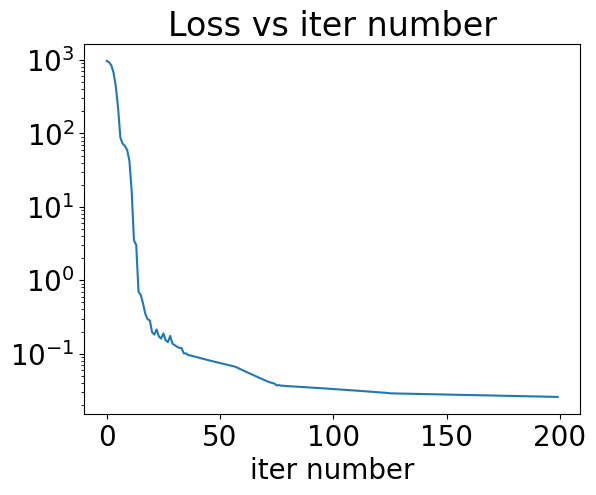

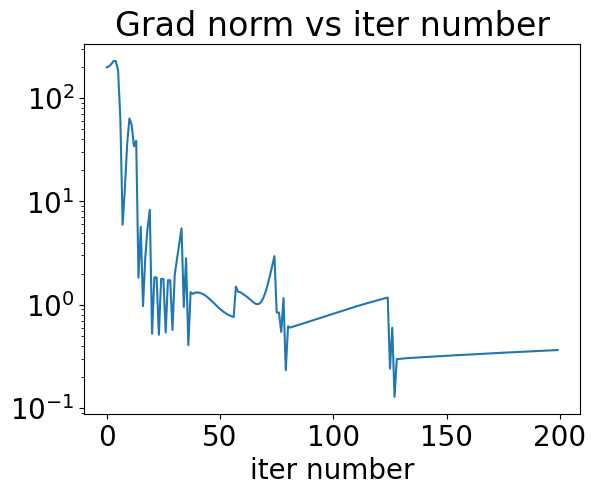

In [373]:
# train neural network
W,Niter,lossvals,gradnormvals = LevenbergMarquardt(Residual_and_Jacobian,xytrain,W)
# plot the loss and the norm of the gradient of the loss
plt.figure()
plt.plot(torch.arange(Niter),lossvals)
plt.title("Loss vs iter number")
plt.yscale("log")
plt.xlabel("iter number")
plt.figure()
plt.plot(np.arange(Niter),gradnormvals)
plt.title("Grad norm vs iter number")
plt.yscale("log")
plt.xlabel("iter number")

Max error =  tensor(0.0321)
Mean error =  tensor(0.0142)
RMS error =  tensor(0.0168)


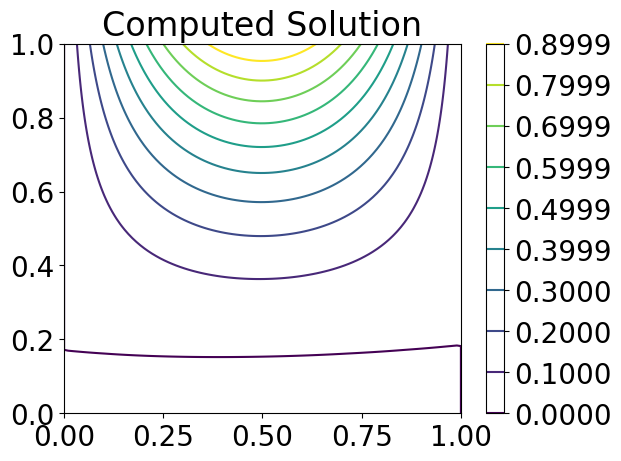

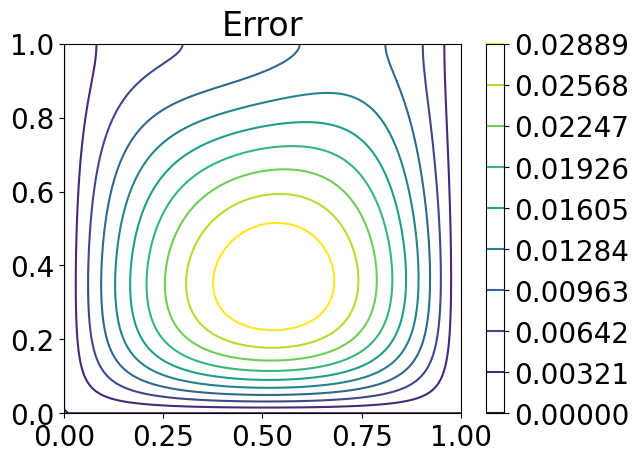

In [374]:
# test the solution
sol_test = torch.zeros(npt2,npt2)
Ntest = torch.numel(sol_test)
for i in range(npt2):
    for j in range(npt2):
        sol_test[i,j] = SolutionModel(xtest_grid[i,j],ytest_grid[i,j],W)
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_test,torch.arange(sol_min,sol_max,0.1*(sol_max-sol_min)))   
plt.colorbar()
plt.title("Computed Solution")
# compare with the exact solution
error = torch.abs(sol_test - sol_exact)
error_vector = torch.reshape(error,(Ntest,1))
error_max = torch.max(error_vector)
plt.figure()
plt.contour(xtest_grid,ytest_grid,error,torch.arange(0.,error_max,error_max*0.1))  
plt.colorbar()
plt.title("Error")
print("Max error = ",torch.max(error_vector))
print("Mean error = ",torch.mean(error_vector))
print("RMS error = ",torch.sqrt(torch.mean(error_vector.pow(2))))

In [396]:
def GradDescent(Res_and_Jac,par,x):
    
    # parameters for GradDescent
    ETA = 0.01 # reject step if rho < ETA 
    ITER_MAX = 100
    TOL = 1.0e-3 # terminate when || grad loss || < tol
    SSIZE = 0.001
    
    # initialization
    r,J = Res_and_Jac(par,x)
    # print(r.size())
    # print(J.size())
    n = J.size(dim = 0) # the number of components of r
    d = J.size(dim = 1) # the number of variables
    lossvals = torch.zeros(ITER_MAX)
    gradnormvals = torch.zeros(ITER_MAX)
    lossvals[0] = Loss(r)
    Jtrans = torch.transpose(J,0,1)
    grad = torch.matmul(Jtrans,r) # grad = J^\top r
    Bmatr = torch.matmul(Jtrans,J) # Bmatr = J^\top J
    gradnorm = torch.linalg.norm(grad)
    gradnormvals[0] = gradnorm
    print("iter 0: loss = ",lossvals[0]," gradnorm = ",gradnorm)
    # start iterations
    i = 1
    while i < ITER_MAX:
        r,J = Res_and_Jac(par,x)
        Jtrans = torch.transpose(J,0,1)
        grad = torch.matmul(Jtrans,r)
        lossvals[i] = Loss(r)
        gradnorm = torch.linalg.norm(grad)
        gradnormvals[i] = gradnorm
        grad_x = -SSIZE*grad
        x = x + grad_x
        print("iter {}: loss = ".format(i),lossvals[i]," gradnorm = ",gradnorm)

        i +=1 
    return x,i,lossvals[0:i], gradnormvals[0:i]                                                  

iter 0: loss =  tensor(1011.4210)  gradnorm =  tensor(192.4611)
iter 1: loss =  tensor(1011.4210)  gradnorm =  tensor(192.4611)
iter 2: loss =  tensor(973.8807)  gradnorm =  tensor(197.8891)
iter 3: loss =  tensor(934.0613)  gradnorm =  tensor(204.5984)
iter 4: loss =  tensor(891.4200)  gradnorm =  tensor(212.0751)
iter 5: loss =  tensor(845.5818)  gradnorm =  tensor(219.8384)
iter 6: loss =  tensor(796.3515)  gradnorm =  tensor(227.4257)
iter 7: loss =  tensor(743.7357)  gradnorm =  tensor(234.3811)
iter 8: loss =  tensor(687.9663)  gradnorm =  tensor(240.2493)
iter 9: loss =  tensor(629.5237)  gradnorm =  tensor(244.5737)
iter 10: loss =  tensor(569.1504)  gradnorm =  tensor(246.8994)
iter 11: loss =  tensor(507.8519)  gradnorm =  tensor(246.7866)
iter 12: loss =  tensor(446.8713)  gradnorm =  tensor(243.8396)
iter 13: loss =  tensor(387.6289)  gradnorm =  tensor(237.7550)
iter 14: loss =  tensor(331.6164)  gradnorm =  tensor(228.3831)
iter 15: loss =  tensor(280.2490)  gradnorm =  t

Text(0.5, 0, 'iter number')

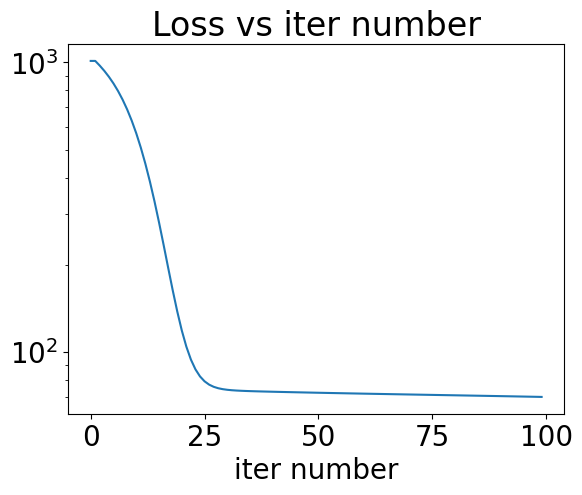

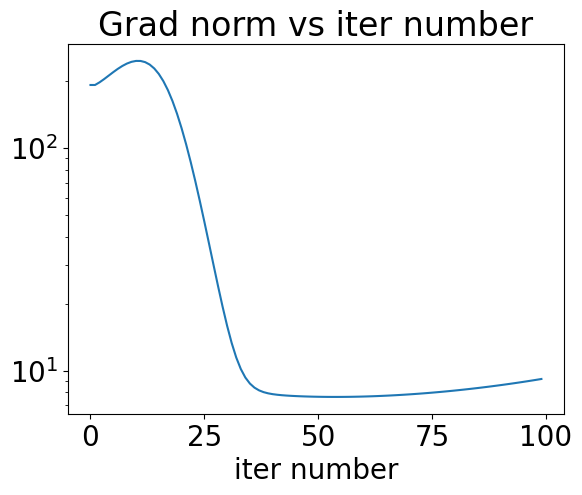

In [398]:
# train neural network
W1,Niter,lossvals,gradnormvals = GradDescent(Residual_and_Jacobian,xytrain,W)
# plot the loss and the norm of the gradient of the loss
plt.figure()
plt.plot(torch.arange(Niter),lossvals)
plt.title("Loss vs iter number")
plt.yscale("log")
plt.xlabel("iter number")
plt.figure()
plt.plot(np.arange(Niter),gradnormvals)
plt.title("Grad norm vs iter number")
plt.yscale("log")
plt.xlabel("iter number")

Max error =  tensor(0.1740)
Mean error =  tensor(0.0440)
RMS error =  tensor(0.0654)


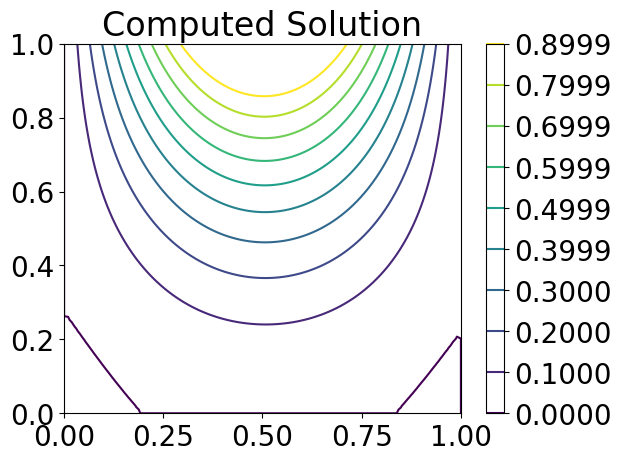

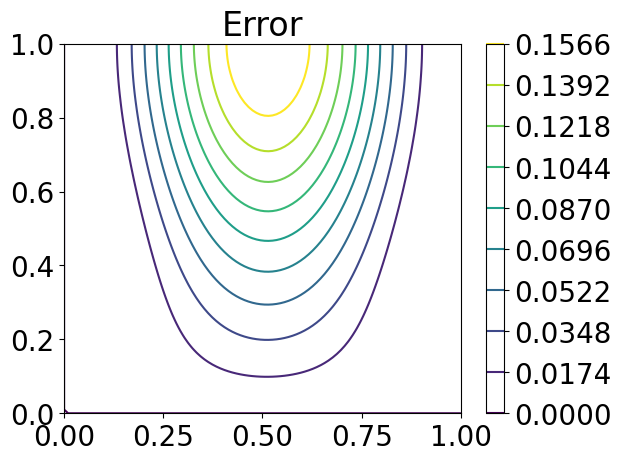

In [399]:
# test the solution
sol_test = torch.zeros(npt2,npt2)
Ntest = torch.numel(sol_test)
for i in range(npt2):
    for j in range(npt2):
        sol_test[i,j] = SolutionModel(xtest_grid[i,j],ytest_grid[i,j],W1)
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_test,torch.arange(sol_min,sol_max,0.1*(sol_max-sol_min)))   
plt.colorbar()
plt.title("Computed Solution")
# compare with the exact solution
error = torch.abs(sol_test - sol_exact)
error_vector = torch.reshape(error,(Ntest,1))
error_max = torch.max(error_vector)
plt.figure()
plt.contour(xtest_grid,ytest_grid,error,torch.arange(0.,error_max,error_max*0.1))  
plt.colorbar()
plt.title("Error")
print("Max error = ",torch.max(error_vector))
print("Mean error = ",torch.mean(error_vector))
print("RMS error = ",torch.sqrt(torch.mean(error_vector.pow(2))))

In [456]:
def Nesterov(Res_and_Jac,par,x):
    
    # parameters for Nesterov
    ETA = 0.01 # reject step if rho < ETA 
    ITER_MAX = 100
    TOL = 1.0e-3 # terminate when || grad loss || < tol
    SSIZE = 0.0001
    
    # initialization
    r,J = Res_and_Jac(par,x)
    # print(r.size())
    # print(J.size())
    n = J.size(dim = 0) # the number of components of r
    d = J.size(dim = 1) # the number of variables
    lossvals = torch.zeros(ITER_MAX)
    gradnormvals = torch.zeros(ITER_MAX)
    lossvals[0] = Loss(r)
    Jtrans = torch.transpose(J,0,1)
    grad = torch.matmul(Jtrans,r) # grad = J^\top r
    Bmatr = torch.matmul(Jtrans,J) # Bmatr = J^\top J
    gradnorm = torch.linalg.norm(grad)
    gradnormvals[0] = gradnorm
    print("iter 0: loss = ",lossvals[0]," gradnorm = ",gradnorm)
    # start iterations
    i = 1
    ox = x
    while i < ITER_MAX:
        r,J = Res_and_Jac(par,x)
        Jtrans = torch.transpose(J,0,1)
        ograd = grad
        grad = torch.matmul(Jtrans,r)
        lossvals[i] = Loss(r)
        gradnorm = torch.linalg.norm(grad)
        gradnormvals[i] = gradnorm
        v_k = x - ox
        mu_k = 1-(3/(5+i))
        r2,J2 = Res_and_Jac(par,mu_k*v_k)
        J2trans = torch.transpose(J2,0,1)
        v_k1 = mu_k*v_k-SSIZE*torch.matmul(J2trans,r2)
        #print(v_k1)
        grad_x = -SSIZE*grad
        ox = x
        x = x + grad_x + v_k1
        print("iter {}: loss = ".format(i),lossvals[i]," gradnorm = ",gradnorm)

        i +=1 
    return x,i,lossvals[0:i], gradnormvals[0:i]                                                  

iter 0: loss =  tensor(1011.4210)  gradnorm =  tensor(192.4611)
iter 1: loss =  tensor(1011.4210)  gradnorm =  tensor(192.4611)
iter 2: loss =  tensor(1007.7104)  gradnorm =  tensor(192.9854)
iter 3: loss =  tensor(1001.8348)  gradnorm =  tensor(193.8388)
iter 4: loss =  tensor(994.3498)  gradnorm =  tensor(194.9609)
iter 5: loss =  tensor(985.4783)  gradnorm =  tensor(196.3347)
iter 6: loss =  tensor(975.3062)  gradnorm =  tensor(197.9585)
iter 7: loss =  tensor(963.8524)  gradnorm =  tensor(199.8357)
iter 8: loss =  tensor(951.0988)  gradnorm =  tensor(201.9695)
iter 9: loss =  tensor(937.0030)  gradnorm =  tensor(204.3604)
iter 10: loss =  tensor(921.5058)  gradnorm =  tensor(207.0041)
iter 11: loss =  tensor(904.5346)  gradnorm =  tensor(209.8895)
iter 12: loss =  tensor(886.0064)  gradnorm =  tensor(212.9977)
iter 13: loss =  tensor(865.8302)  gradnorm =  tensor(216.3004)
iter 14: loss =  tensor(843.9096)  gradnorm =  tensor(219.7585)
iter 15: loss =  tensor(820.1457)  gradnorm = 

Text(0.5, 0, 'iter number')

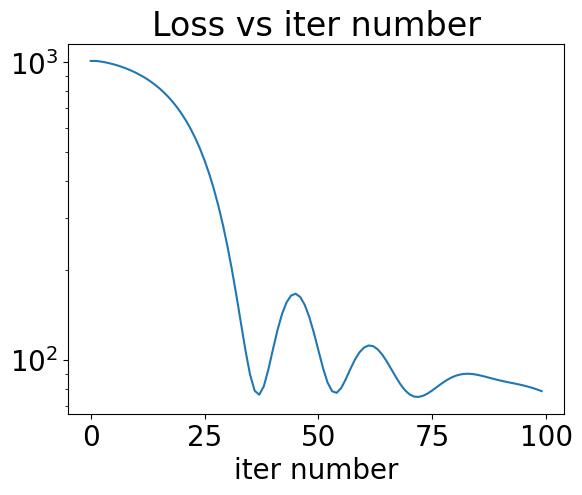

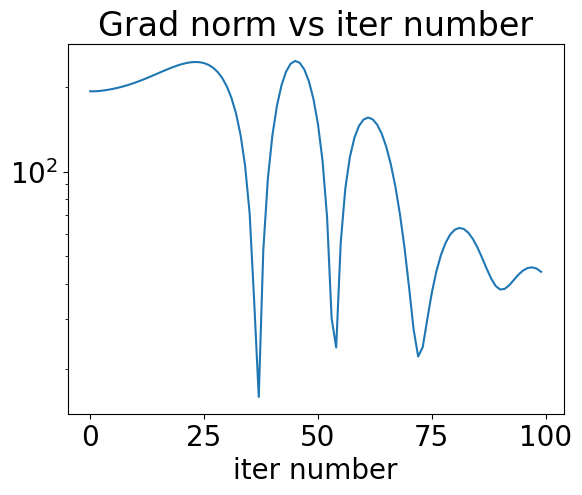

In [457]:
# train neural network
W2,Niter,lossvals,gradnormvals = Nesterov(Residual_and_Jacobian,xytrain,W)
# plot the loss and the norm of the gradient of the loss
plt.figure()
plt.plot(torch.arange(Niter),lossvals)
plt.title("Loss vs iter number")
plt.yscale("log")
plt.xlabel("iter number")
plt.figure()
plt.plot(np.arange(Niter),gradnormvals)
plt.title("Grad norm vs iter number")
plt.yscale("log")
plt.xlabel("iter number")

Max error =  tensor(0.2382)
Mean error =  tensor(0.0640)
RMS error =  tensor(0.0933)


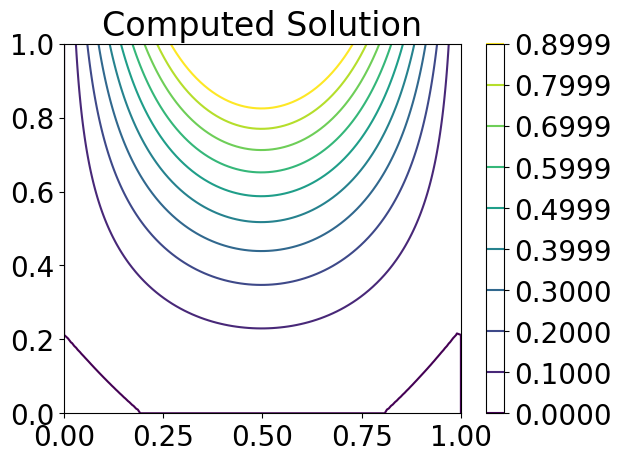

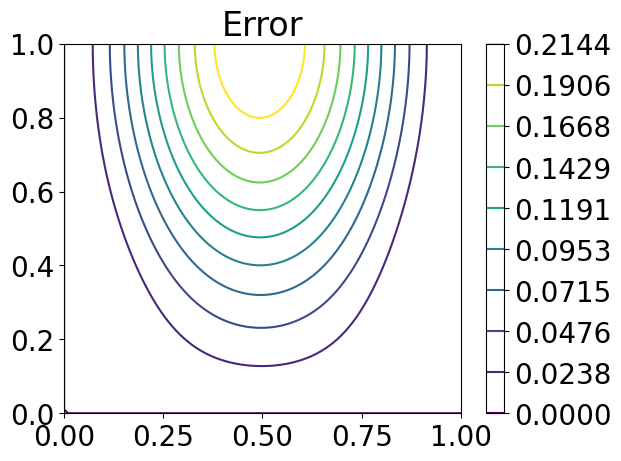

In [458]:
# test the solution
sol_test = torch.zeros(npt2,npt2)
Ntest = torch.numel(sol_test)
for i in range(npt2):
    for j in range(npt2):
        sol_test[i,j] = SolutionModel(xtest_grid[i,j],ytest_grid[i,j],W2)
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_test,torch.arange(sol_min,sol_max,0.1*(sol_max-sol_min)))   
plt.colorbar()
plt.title("Computed Solution")
# compare with the exact solution
error = torch.abs(sol_test - sol_exact)
error_vector = torch.reshape(error,(Ntest,1))
error_max = torch.max(error_vector)
plt.figure()
plt.contour(xtest_grid,ytest_grid,error,torch.arange(0.,error_max,error_max*0.1))  
plt.colorbar()
plt.title("Error")
print("Max error = ",torch.max(error_vector))
print("Mean error = ",torch.mean(error_vector))
print("RMS error = ",torch.sqrt(torch.mean(error_vector.pow(2))))

In [481]:
def Adam(Res_and_Jac,par,x):
    
    # parameters for Nesterov
    ITER_MAX = 100
    TOL = 1.0e-3 # terminate when || grad loss || < tol
    SSIZE = 0.0001
    B1, B2 = 0.9, 0.999
    epsilon = 10e-8
    
    # initialization
    r,J = Res_and_Jac(par,x)
    # print(r.size())
    # print(J.size())
    n = J.size(dim = 0) # the number of components of r
    d = J.size(dim = 1) # the number of variables
    lossvals = torch.zeros(ITER_MAX)
    gradnormvals = torch.zeros(ITER_MAX)
    lossvals[0] = Loss(r)
    Jtrans = torch.transpose(J,0,1)
    grad = torch.matmul(Jtrans,r) # grad = J^\top r
    Bmatr = torch.matmul(Jtrans,J) # Bmatr = J^\top J
    gradnorm = torch.linalg.norm(grad)
    gradnormvals[0] = gradnorm
    print("iter 0: loss = ",lossvals[0]," gradnorm = ",gradnorm)
    # start iterations
    i = 1
    m = 0
    v = 0
    while gradnorm > TOL and i < ITER_MAX :
        r,J = Res_and_Jac(par,x)
        Jtrans = torch.transpose(J,0,1)
        grad = torch.matmul(Jtrans,r)
        m = B1*m+(1-B1)*grad
        v = B2*v+(1-B2)*grad.pow(2)
        mhat = m/(1-B1**i)
        vhat = v/(1-B2**i)
        x = x-(SSIZE*mhat/(np.sqrt(vhat)+epsilon))
        lossvals[i] = Loss(r)
        gradnorm = torch.linalg.norm(grad)
        gradnormvals[i] = gradnorm
        print("iter {}: loss = ".format(i),lossvals[i]," gradnorm = ",gradnorm)

        i +=1 
    return x,i,lossvals[0:i], gradnormvals[0:i]                                                  

iter 0: loss =  tensor(1011.4210)  gradnorm =  tensor(192.4611)
iter 1: loss =  tensor(1011.4210)  gradnorm =  tensor(192.4611)
iter 2: loss =  tensor(1011.3429)  gradnorm =  tensor(192.4904)
iter 3: loss =  tensor(1011.2647)  gradnorm =  tensor(192.5198)
iter 4: loss =  tensor(1011.1866)  gradnorm =  tensor(192.5491)
iter 5: loss =  tensor(1011.1084)  gradnorm =  tensor(192.5785)
iter 6: loss =  tensor(1011.0303)  gradnorm =  tensor(192.6078)
iter 7: loss =  tensor(1010.9521)  gradnorm =  tensor(192.6372)
iter 8: loss =  tensor(1010.8738)  gradnorm =  tensor(192.6665)
iter 9: loss =  tensor(1010.7956)  gradnorm =  tensor(192.6959)
iter 10: loss =  tensor(1010.7173)  gradnorm =  tensor(192.7253)
iter 11: loss =  tensor(1010.6390)  gradnorm =  tensor(192.7546)
iter 12: loss =  tensor(1010.5607)  gradnorm =  tensor(192.7840)
iter 13: loss =  tensor(1010.4824)  gradnorm =  tensor(192.8134)
iter 14: loss =  tensor(1010.4040)  gradnorm =  tensor(192.8428)
iter 15: loss =  tensor(1010.3256) 

Text(0.5, 0, 'iter number')

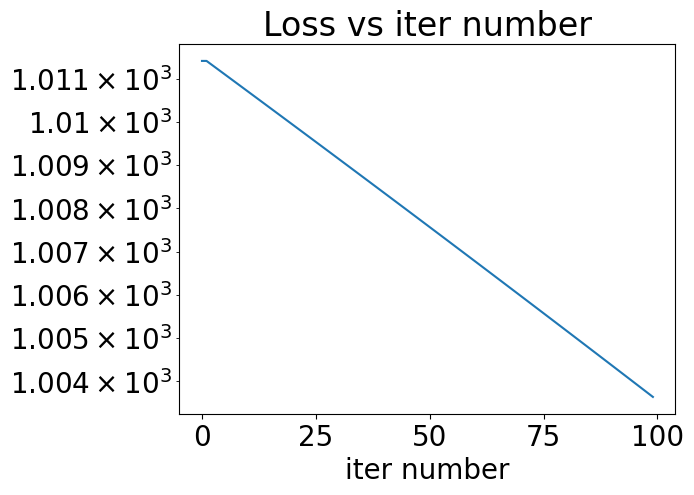

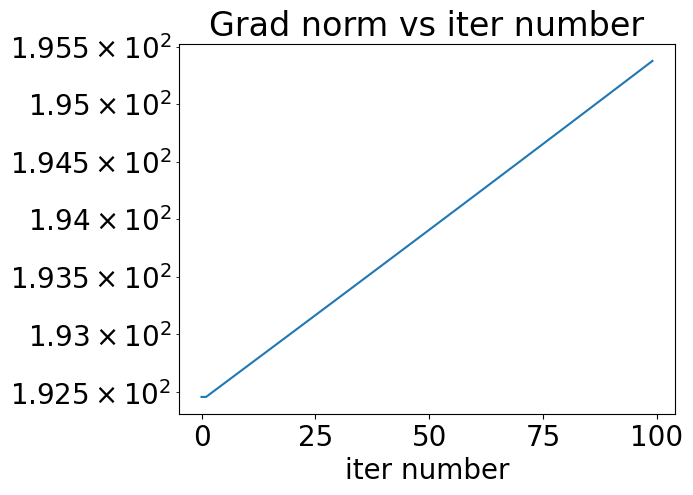

In [482]:
# train neural network
W3,Niter,lossvals,gradnormvals = Adam(Residual_and_Jacobian,xytrain,W)
# plot the loss and the norm of the gradient of the loss
plt.figure()
plt.plot(torch.arange(Niter),lossvals)
plt.title("Loss vs iter number")
plt.yscale("log")
plt.xlabel("iter number")
plt.figure()
plt.plot(np.arange(Niter),gradnormvals)
plt.title("Grad norm vs iter number")
plt.yscale("log")
plt.xlabel("iter number")

Max error =  tensor(0.9211)
Mean error =  tensor(0.3836)
RMS error =  tensor(0.4711)


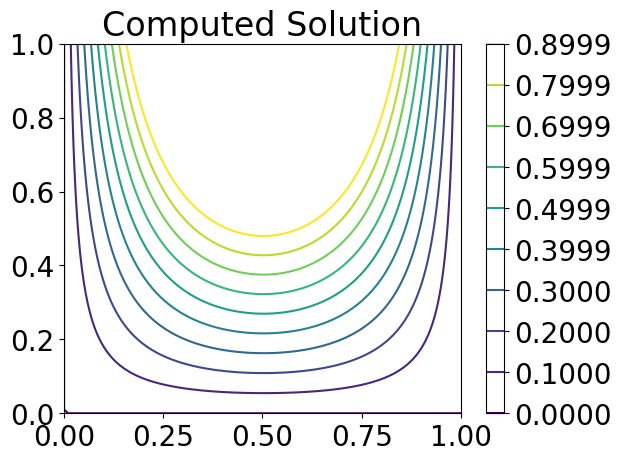

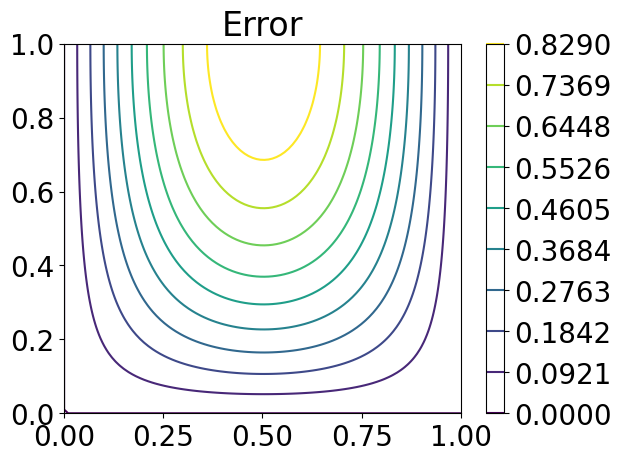

In [483]:
# test the solution
sol_test = torch.zeros(npt2,npt2)
Ntest = torch.numel(sol_test)
for i in range(npt2):
    for j in range(npt2):
        sol_test[i,j] = SolutionModel(xtest_grid[i,j],ytest_grid[i,j],W3)
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_test,torch.arange(sol_min,sol_max,0.1*(sol_max-sol_min)))   
plt.colorbar()
plt.title("Computed Solution")
# compare with the exact solution
error = torch.abs(sol_test - sol_exact)
error_vector = torch.reshape(error,(Ntest,1))
error_max = torch.max(error_vector)
plt.figure()
plt.contour(xtest_grid,ytest_grid,error,torch.arange(0.,error_max,error_max*0.1))  
plt.colorbar()
plt.title("Error")
print("Max error = ",torch.max(error_vector))
print("Mean error = ",torch.mean(error_vector))
print("RMS error = ",torch.sqrt(torch.mean(error_vector.pow(2))))